<a href="https://colab.research.google.com/github/yasminef98/KaggleCompetition_CNN/blob/main/histopathologic_cancer_detection_using_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Import

In [ ]:
# Ensure you have the latest version of Kaggle API
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.9-cp36-none-any.whl size=73265 sha256=aa594a162f7aa4f398ac33f621071dfd0784d2bced789083bda5e590c32d63b9
  Stored in directory: /root/.cache/pip/wheels/68/6d/9b/7a98271454edcba3b56328cbc78c037286e787d004c8afee71
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


In [ ]:
# Download your kaggle.json credentials file from your Kaggle account page. 
# (Make sure you approve their user agreement/competition rules before downloading the file.)
# Upload it here
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Check if Kaggle works
! kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
# Get the competition dataset 
!kaggle competitions download -c histopathologic-cancer-detection -p 'dataset'

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
! unzip /content/dataset/histopathologic-cancer-detection.zip

unzip:  cannot find or open /content/dataset/histopathologic-cancer-detection.zip, /content/dataset/histopathologic-cancer-detection.zip.zip or /content/dataset/histopathologic-cancer-detection.zip.ZIP.


# Let's get started

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
base_dir = './'  # Changez-le en fonction de votre environnement colab ou jupyter notebook local

# Matplotlib for visualization
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# OpenCV Image Library
import cv2

# Import PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

# Import useful sklearn functions
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image

In [ ]:
full_train_df = pd.read_csv("./train_labels.csv")
full_train_df.head()

In [ ]:
print("Train Size: {}".format(len(os.listdir('./train/'))))
print("Test Size: {}".format(len(os.listdir('./test/'))))

Train Size: 220025
Test Size: 57458


Train Size: 80% of the dataset. Test Size: 20% of the dataset

# Exploratory Data Analysis 

**label**: 0 si pas de cancer , 1 si présence de cancer
value_counts permet de compter chaque element présent dans la colonne label


In [ ]:
labels_count = full_train_df.label.value_counts()
print(labels_count)

0    130908
1     89117
Name: label, dtype: int64


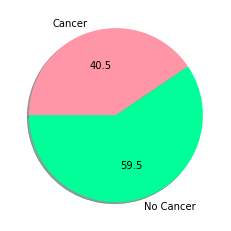

<Figure size 1152x1152 with 0 Axes>

In [ ]:
%matplotlib inline
plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=180, 
        autopct='%1.1f', colors=['#00ff99','#FF96A7'], shadow=True)
plt.figure(figsize=(16,16))
plt.show()

Comme les 1 (présence de cancer) ne représentent que 40%, soit 89 117, nous ne prendrons que 80 000 de 1 et 80 000 de 0 pour avoir un ensemble de formation équilibré.

# Visualisation D'images
Problème : La classification des métastases n'est pas une tâche facile pour un histo-pathologiste qualifié et extrêmement difficile pour un œil non entraîné lorsque nous regardons l'image.

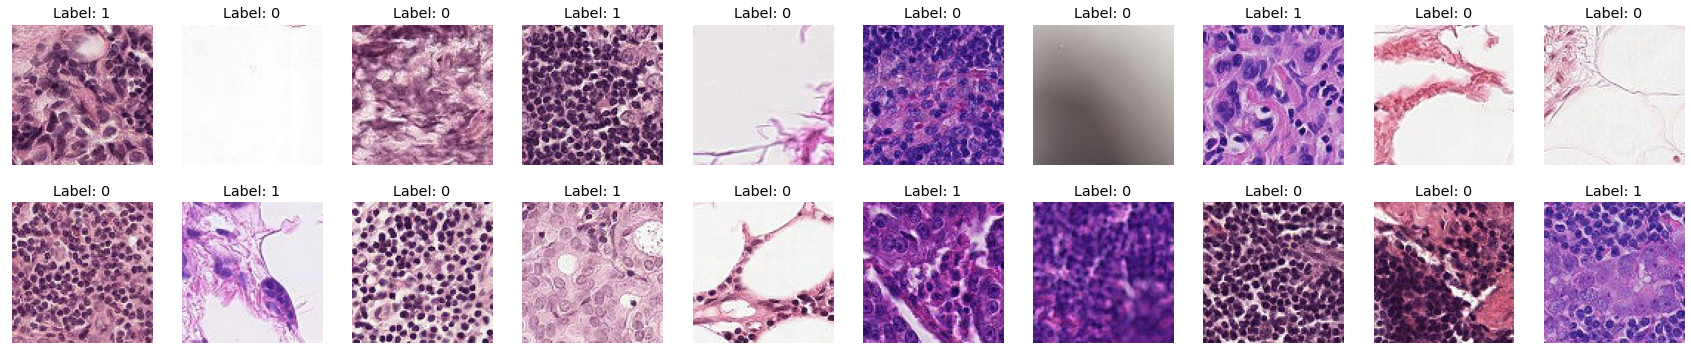

In [ ]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(base_dir+"train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"train/" + img)
    plt.imshow(im)
    lab = full_train_df.loc[full_train_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

# Sampling
 

But du "Sampling" avoir une proportion d'images histologiques "cancéreuses et "non cancereuses" égale afin de ne pas "habituer" le modèle à reconnaitre d'avantage les images non cancéreuses. On prendra 80 000 images pour chaque catégorie.

In [ ]:
# Number of samples in each class
SAMPLE_SIZE = 80000

# Data paths
train_path = './train/'
test_path = './test/'

# Use 80000 positive and negative examples
df_negatives = full_train_df[full_train_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = full_train_df[full_train_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dfs and shuffle them up
train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True)) #melange du tableau

train_df.shape

(160000, 2)

# Data Pre-processing 
 Création de la classe permettant la transformation des données en un ensemble de données PyTorch

In [ ]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values #recuperation du data frame en format numpy
        self.data_dir = data_dir #recupération de l'emplacement des données
        self.transform = transform #application de la transformation definie dans la cellule qui suit 

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index] #recuperation ID des images et du label (0 ou 1) associé
        img_path = os.path.join(self.data_dir, img_name+'.tif') #recupération de l'image 
        image = cv2.imread(img_path) #lecture de l'image
        if self.transform is not None: #transformation de l'image (transformation effectuée defini dans la cellule qui suit)
            image = self.transform(image) 
        return image, label #retourne en sortie l'image et le label associé

In [ ]:
transforms_train = transforms.Compose([
    #Converti un tenseur ou un tableau de bord en image PIL (Python Image Library)                               
    transforms.ToPILImage(), 
    #Retourner horizontalement l'image donnée au hasard avec une probabilité donnée, ici 0.4
    transforms.RandomHorizontalFlip(p=0.4),
    #Retourner verticalement l'image donnée au hasard avec une probabilité donnée, ici 0.4
    transforms.RandomVerticalFlip(p=0.4),
    #Fait pivoter l'image par angle, ici 20
    transforms.RandomRotation(20),
    #transforme l'image PIL en Tensor
    transforms.ToTensor(),
    #Normaliser l'image : moyenne pour chaque chanel RGB, ecart type de chaque chanel RGB transforms.Normalize(mean(R, G, B), std(R, G, B))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



In [ ]:

train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)

In [ ]:
# Set Batch Size
batch_size = 128
##CREATION D UN JEU DE VALIDATION 
#pourcentage du jeu d'entrainement utilisé pour le jeu de validation
valid_size = 0.1  # 160 000 => 10% = 16000

#split = indice du dernier element du jeu de validation
num_train = len(train_data)
split = int(np.floor(valid_size * num_train)) 
print(split)

#liste des indices du jeu de validation
indices = list(range(num_train))

16000


In [ ]:
#les images d'index 0 à 15999 seront dans le jeu de validation , de 16000 à 79999 dans le jeu de d'entrainement
valid_idx, train_idx = indices[:split], indices[split:]

In [ ]:
# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

In [ ]:
#Definition de la transformation des images du jeu de test (pas de retournement horizontal,vertical, pivotement contrairement aux images du de d'entrainement et validation )
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# creation des données de test
sample_sub = pd.read_csv("./sample_submission.csv")
test_data = CreateDataset(df_data=sample_sub, data_dir=test_path, transform=transforms_test)

# prepare the test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Defining Model Architecture
Modèle CNN utilisé



In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Convolutional and Pooling Layers
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),#application d'une convolution 2D, in_channels : 
              # canaux dans l'image d'entrée, out_channel : nombre de canaux produit par la convolution)
                nn.BatchNorm2d(32), #"normalisation par lot" " technique qui peut améliorer le taux d'apprentissage d'un réseau neuronal"
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2)) #reduction taille matrice, premier paramètres kernel, deuxieme parmètre stride : permet reduction des données de 2
        self.conv2=nn.Sequential(
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv4=nn.Sequential(
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv5=nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        
        self.dropout2d = nn.Dropout2d() #Remise à zéro aléatoirement des channels
        
        
        self.fc=nn.Sequential(
                nn.Linear(512*3*3,1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(1024,512),
                nn.Dropout(0.4),
                nn.Linear(512, 1),
                nn.Sigmoid())
        
    def forward(self,x): ##accepte un tensor en entrée et renvoie un tensor de sortie
    #utilisera toutes les couches que nous avons définies à l'intérieur du constructeur
    #définit explicitement la transformation du réseau.
        """Method for Forward Prop"""
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

###BatchNorm2d : Batch Propagation : 



*   permet d'améliorer le taux d'apprentissage du réseau neuronal
*   minimise le "glissement" des covariables internes,(phénomène de la distribution des entrées de chaque couche qui change au fur et à mesure que les paramètres de la couche supérieure changent pendant l'apprentissage)




In [ ]:
#le deuxième layer 
x = self.layer2(x)
#a une distribution attendue des entrées provenant de la première couche 
x = self.layer1(x)
#ses paramètres sont optimisés pour cette distribution attendue.
#Au fur et à mesure que les paramètres de la première couche sont mis à jour (au fur et à mesure des essaies réalisé celon nombre d'epoch), 
#cette distribution attendue ressemble de moins en moins à une distribution réelle transmise par la couche 1
#peut entrainer une saturation lors du passage à la seconde couche et un ralentissement du temps de traitement

#La Batch Propagation permet d'utiliser un epoch plus elevée (permet de plus entrainer notre modèle)
#tout en ne se préoccupant pas autant du glissement des covariables internes.


In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Training and Validation

In [ ]:
# create a complete CNN
model = CNN()
print(model)

# Move model to GPU if available
if train_on_gpu: model.cuda()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [ ]:
# Trainable Parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6805249


In [ ]:
# specify loss function (categorical cross-entropy loss)
criterion = nn.BCELoss()

# Binary Cross entropy fonction , utilisé pour les classifications binaires
#formule  : -1/taille de sortie sum(y-log (y^)+(1-y)*log(1-y^) )



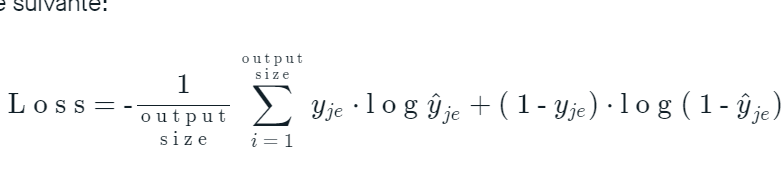

###Optimisation Adam : 





In [ ]:
#équations réelles d'Adam :
m = beta1 * m + (1 - beta1) * dx 
mt = m / (1 - beta1 ** t) 
v = beta2 * v + (1 - beta2) * (dx ** 2) 
vt = v / (1 - beta2 ** t) 
x + =  - taux_apprentissage * mt / (np . sqrt (vt) + eps)

In [ ]:
specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015)

#Adam :  méthode d'optimisation stochastique
#"technique mettant en œuvre un taux d'apprentissage adaptatif"

In [ ]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf

# keeping track of losses as it happen
train_losses = []
valid_losses = []
val_auc = []
test_accuracies = []
valid_accuracies = []
auc_epoch = []

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1)
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        #output = output.topk()
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))        
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))
    
    ##################
    # Early Stopping #
    ##################
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 | Training Loss: 0.360598 | Validation Loss: 0.320682 | Validation AUC: 0.9454
Validation loss decreased (inf --> 0.320682).  Saving model ...
Epoch: 2 | Training Loss: 0.294126 | Validation Loss: 0.263315 | Validation AUC: 0.9518
Validation loss decreased (0.320682 --> 0.263315).  Saving model ...
Epoch: 3 | Training Loss: 0.262206 | Validation Loss: 0.260420 | Validation AUC: 0.9544
Validation loss decreased (0.263315 --> 0.260420).  Saving model ...
Epoch: 4 | Training Loss: 0.238380 | Validation Loss: 0.248376 | Validation AUC: 0.9580
Validation loss decreased (0.260420 --> 0.248376).  Saving model ...
Epoch: 5 | Training Loss: 0.219317 | Validation Loss: 0.246330 | Validation AUC: 0.9600
Validation loss decreased (0.248376 --> 0.246330).  Saving model ...
Epoch: 6 | Training Loss: 0.206188 | Validation Loss: 0.249320 | Validation AUC: 0.9618
Epoch: 7 | Training Loss: 0.195728 | Validation Loss: 0.186009 | Validation AUC: 0.9643
Validation loss decreased (0.246330 --> 0.18

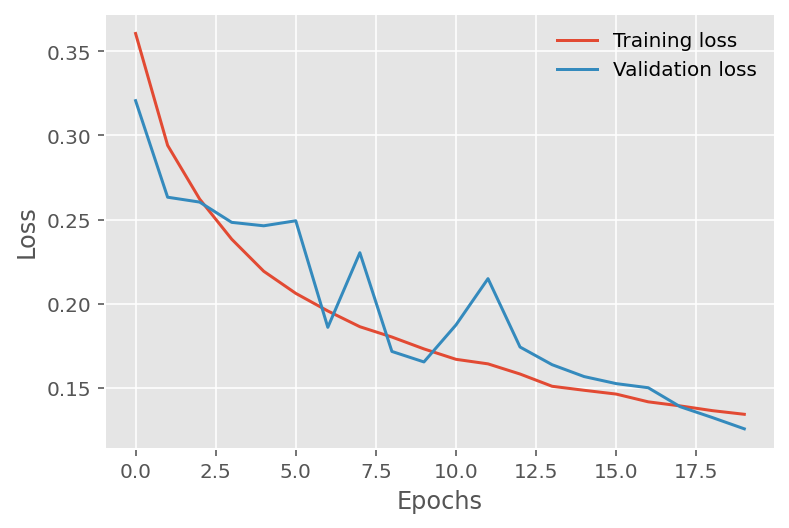

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

#Metric utilisée : ROC-AUC 

La courbe AUC  est une mesure de performance pour les problèmes de classification. Elle indique dans quelle mesure le modèle est capable de distinguer entre les classes. 

Ici, il a été representé l'evolution de la métrique en fonction des epoch choisi.







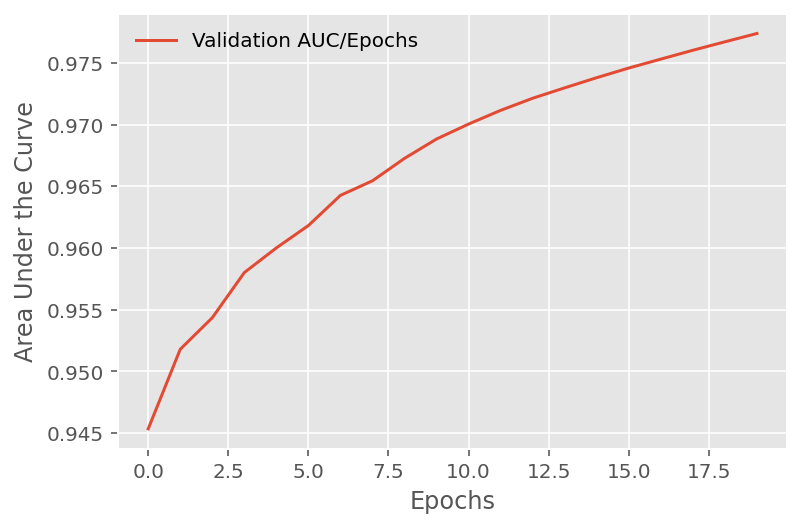

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(auc_epoch, label='Validation AUC/Epochs')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("Area Under the Curve")
plt.legend(frameon=False)

In [ ]:
# Load Best parameters learned from training into our model to make predictions later
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

# Predictions on Test set

In [ ]:
# Turn off gradients
model.eval()

preds = []
for batch_i, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output.detach().cpu().numpy()
    for i in pr:
        preds.append(i)

# Create Submission file        
sample_sub['label'] = preds

In [ ]:
for i in range(len(sample_sub)):
    sample_sub.label[i] = np.float(sample_sub.label[i]) 

In [ ]:
sample_sub.to_csv('submission.csv', index=False)
sample_sub.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.00622873
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.254753
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.0231894
3,2c35657e312966e9294eac6841726ff3a748febf,0.000390046
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.0128795


# Visualizing Preditions:

In [ ]:
def imshow(img):
    '''Helper function to un-normalize and display an image'''
    # unnormalize
    img = img / 2 + 0.5
    # convert from Tensor image and display
    plt.imshow(np.transpose(img, (1, 2, 0)))

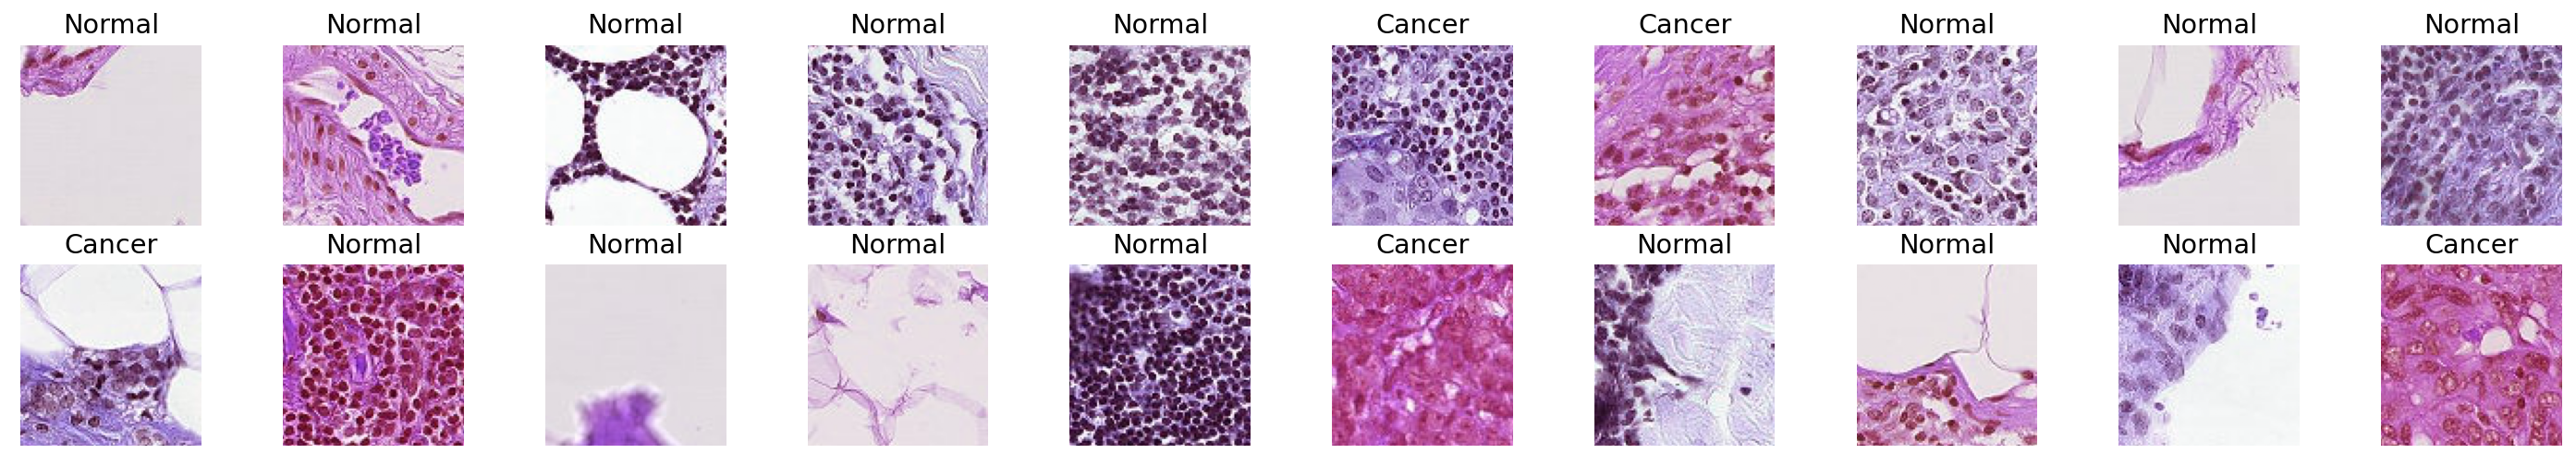

In [ ]:
# obtain one batch of training images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    prob = "Cancer" if(sample_sub.label[idx] >= 0.5) else "Normal" 
    ax.set_title('{}'.format(prob))